# 🛍️ Sales Forecasting & Inventory Optimization – Walmart

**Objective:**  
Use historical data from Walmart stores to predict future weekly sales and optimize inventory planning using machine learning.

**Business Problem:**  
Walmart needs accurate forecasts to reduce overstocking/stockouts and improve marketing ROI. Our goal is to model weekly sales per store using economic indicators, markdowns, holidays, and lag-based features.


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
stores = pd.read_csv("C:/Users/User/Desktop/PROJECTS/Sales Forecasting & Inventory Optimization/stores.csv")
features = pd.read_csv("C:/Users/User/Desktop/PROJECTS/Sales Forecasting & Inventory Optimization/features.csv")
train = pd.read_csv("C:/Users/User/Desktop/PROJECTS/Sales Forecasting & Inventory Optimization/train.csv")

## 📥 Data Overview

We use 3 datasets:
- `train.csv`: Weekly sales per store & department
- `features.csv`: External variables like markdowns, temperature, and holiday flags
- `stores.csv`: Store metadata (type & size)

We merge these datasets to build a unified modeling base.


In [3]:
stores.head() 

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
stores.shape

(45, 3)

In [5]:
stores.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [6]:
stores.describe() 

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [7]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
features.shape

(8190, 12)

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [10]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [11]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [12]:
train.shape

(421570, 5)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [14]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [15]:
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [16]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [17]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [18]:
# Convert Date to datetime
features['Date'] = pd.to_datetime(features['Date'], errors='coerce')
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'],  errors='coerce')


In [19]:
# Handle missing values, if any
features.dropna(inplace=True)  # Drop rows with any missing values


In [20]:
features.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [21]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

# We use train because it has all the valuable information and then features

In [22]:
df = pd.merge( train,features, how='left', on =['Store','Date'])
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2010-02-26,19403.54,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2010-03-05,21827.90,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.5,1601.01,3288.25,192.013558,8.684,False
421566,45,98,2012-10-05,628.10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421567,45,98,2012-10-12,1061.02,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421568,45,98,2012-10-19,760.01,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data = pd.merge(df, stores, how='left', on= ['Store'])
data

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
1,1,1,2010-02-12,46039.49,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
2,1,1,2010-02-19,41595.55,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
3,1,1,2010-02-26,19403.54,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
4,1,1,2010-03-05,21827.90,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.5,1601.01,3288.25,192.013558,8.684,False,B,118221
421566,45,98,2012-10-05,628.10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221
421567,45,98,2012-10-12,1061.02,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221
421568,45,98,2012-10-19,760.01,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,118221


In [24]:
data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature     324514
Fuel_Price      324514
MarkDown1       324514
MarkDown2       324514
MarkDown3       324514
MarkDown4       324514
MarkDown5       324514
CPI             324514
Unemployment    324514
IsHoliday_y     324514
Type                 0
Size                 0
dtype: int64

## 🧹 Data Cleaning

- Converted `Date` columns to datetime
- Handled missing markdowns by imputing 0 (no promotion)
- Forward + backward filled `CPI`, `Unemployment`, `Fuel_Price`, and `Temperature`
- Dropped duplicate holiday flags and renamed for clarity


In [25]:
data['MarkDown1'].fillna(value = 0,inplace = True)
data['MarkDown2'].fillna(value = 0,inplace = True)
data['MarkDown3'].fillna(value = 0,inplace = True)
data['MarkDown4'].fillna(value = 0,inplace = True)
data['MarkDown5'].fillna(value = 0,inplace = True)
data['CPI'].ffill(axis = 0, inplace = True)
data['Unemployment'].ffill(axis = 0, inplace = True)
data['Fuel_Price'].ffill(axis = 0, inplace = True)
data['Temperature'].ffill(axis = 0, inplace = True)
data.drop('IsHoliday_y', axis = 1, inplace = True)
# no more frowar fill left so we use backward fill
data['CPI'].bfill(axis = 0, inplace = True)
data['Unemployment'].bfill(axis = 0, inplace = True)
data['Fuel_Price'].bfill(axis = 0, inplace = True)
data['Temperature'].bfill(axis = 0, inplace = True)
data.rename(columns= {'IsHoliday_x':'Holiday'}, inplace = True)

In [26]:
data.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Holiday         0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [27]:
data.head()

,Store,Dept,Date,Weekly_Sales,Holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,59.11,3.297,0.0,0.0,0.0,0.0,0.0,217.998085,7.866,A,151315
1,1,1,2010-02-12,46039.49,True,59.11,3.297,0.0,0.0,0.0,0.0,0.0,217.998085,7.866,A,151315
2,1,1,2010-02-19,41595.55,False,59.11,3.297,0.0,0.0,0.0,0.0,0.0,217.998085,7.866,A,151315
3,1,1,2010-02-26,19403.54,False,59.11,3.297,0.0,0.0,0.0,0.0,0.0,217.998085,7.866,A,151315
4,1,1,2010-03-05,21827.90,False,59.11,3.297,0.0,0.0,0.0,0.0,0.0,217.998085,7.866,A,151315


In [28]:
data['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [29]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

data = data.sort_values(['Store', 'Date'])
data['sales_lag_1'] = data.groupby('Store')['Weekly_Sales'].shift(1).fillna(0)
data['sales_lag_2'] = data.groupby('Store')['Weekly_Sales'].shift(2).fillna(0)

# Round Off for better understanding 
data['CPI'] = data['CPI'].round(2)
data['Unemployment'] = data['Unemployment'].round(2)
data['Fuel_Price'] = data['Fuel_Price'].round(2)

data_encoded = data.copy()

le = LabelEncoder()
data_encoded['Type'] = le.fit_transform(data_encoded['Type'])
data_encoded['Holiday'] = le.fit_transform(data_encoded['Holiday'])

## 🧠 Feature Engineering

Created time-based features:
- `Year`, `Month`, `Week` – to capture seasonality
- `sales_lag_1`, `sales_lag_2` – past performance memory

Encoded categorical columns:
- `Type` (A/B/C)
- `Holiday` (True/False)

All features were scaled or transformed as required for XGBoost.


In [30]:
X = data.drop(['Weekly_Sales', 'Date'], axis=1)
y = data['Weekly_Sales']

#Split 
train_data = data_encoded[data_encoded['Year'] < 2012]
test_data = data_encoded[data_encoded['Year'] >= 2012]

X_train = train_data.drop(['Weekly_Sales', 'Date'], axis=1)
y_train = train_data['Weekly_Sales']

X_test = test_data.drop(['Weekly_Sales', 'Date'], axis=1)
y_test = test_data['Weekly_Sales']



## 🤖 Model Training

Used XGBoost Regressor with:
- 100 trees
- max_depth = 6
- learning_rate = 0.1

Data was split using **time-based cutoff**:
- Train = Before 2012
- Test = 2012 onwards


In [31]:
model = XGBRegressor(n_estimators = 100, learning_rate =0.1, max_depth = 6, random_state =42)
model.fit(X_train, y_train)
                     

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## 📊 Evaluation

**Results:**
- RMSE: ₹6742
- MAE: ₹4207
- R² Score: 90.7%

✅ Model explains ~91% of the variance in weekly sales.


In [35]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:',r2)

RMSE: 6742.409741430395
MAE: 4207.65803310945
R2 Score: 0.907094352290878


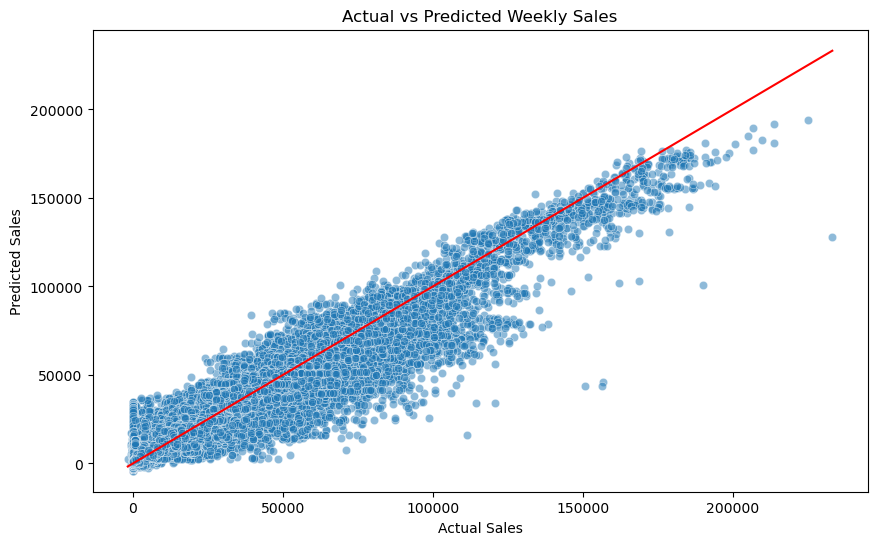

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Weekly Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # Diagonal
plt.show()


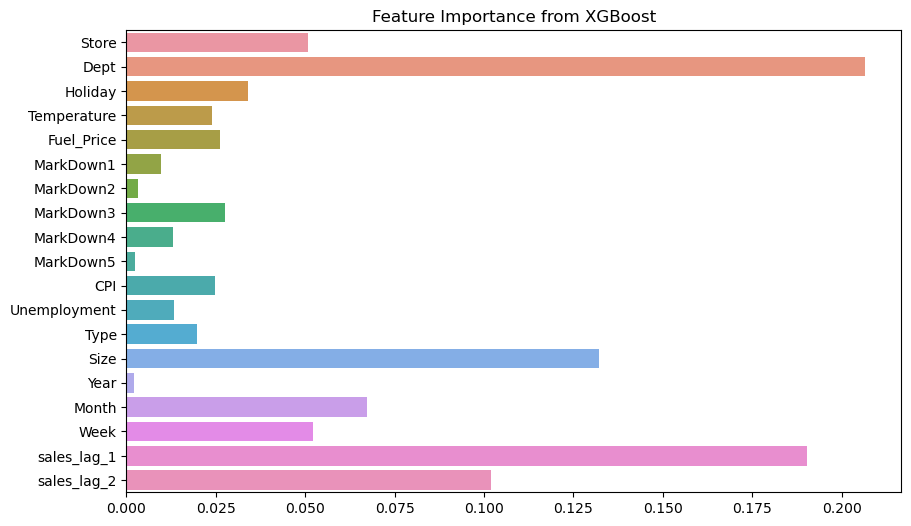

In [37]:
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance from XGBoost")
plt.show()


## 🎯 Business Insights & Recommendations

- Use forecasts to optimize inventory orders per store-week.
- Plan promotions around holidays and markdown strategies.
- Lag-based patterns suggest opportunity for auto-replenishment logic.
- High accuracy enables better workforce and logistics planning.

Next Steps:
- Integrate forecasts into Power BI dashboard for regional managers.
- Improve by tuning hyperparameters and experimenting with LSTM or Prophet for long-term forecasting.
